
# Reducing a moiré pattern using notch filters 

In [1]:
# Importings

import itertools
import cv2, cmath
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Functions

def D_k(u, v, P, Q, uk, vk):
    return np.sqrt((u - P/2 - uk)**2 + (v - Q/2 - vk)**2)

def high_pass_filter(P, Q, D0, n, uk, vk, name):
    u = np.array(range(P))
    v = np.array(range(Q))

    coordinates = list(itertools.product(u, v))
    coordinates.sort(key=lambda x: x[0])
    
    if name == "IHPF" :
        f_h = lambda t: 0 if D_k(t[0], t[1], P, Q, uk, vk) <= D0 else 1
        
    elif name == "BHPF":
        f_h = lambda t: 1/(1 + ( D0/D_k(t[0], t[1], P, Q, uk, vk) )**(2*n) )

    elif name == "GHPF":
        f_h = lambda t: 1 - np.exp(- ( ( D_k( t[0], t[1], P, Q, uk, vk)**2 )/(2*(D0**2)) ))
        
    hpf = np.array(list(map(f_h, coordinates)))
    hpf = np.reshape(hpf, (P, Q))
    
    return hpf

def show2(img1, caption1, img2, caption2, SIZE = 15):
    plt.figure(figsize = (SIZE, SIZE))
    plt.subplot(231),plt.imshow(img1, cmap = "gray"); plt.title(caption1); plt.axis("off")
    plt.subplot(232),plt.imshow(img2, cmap = "gray"); plt.title(caption2); plt.axis("off")
    plt.show()

def reject_notch_filter(height, width, notch_h, notch_w, D0, n, name):
    H = np.ones((height, width))
    for uk,vk in itertools.product(notch_h, notch_w):
        hpf = high_pass_filter(height, width, D0, n, uk, vk, name)
        H = H*hpf
    return H

def apply_rn_filter(imgshift, rn_filter):    
    prod = imgshift*rn_filter
    log_spec = 1 + np.log(np.abs(prod))

    ishift_prod = np.fft.ifftshift(prod)
    ifft_prod = np.fft.ifft2(ishift_prod)

    filtered = ifft_prod.real[:img.shape[0], :img.shape[1]]

    show2(filtered, "Filtered Image", log_spec, "Magnitude Spectrum (Log)")

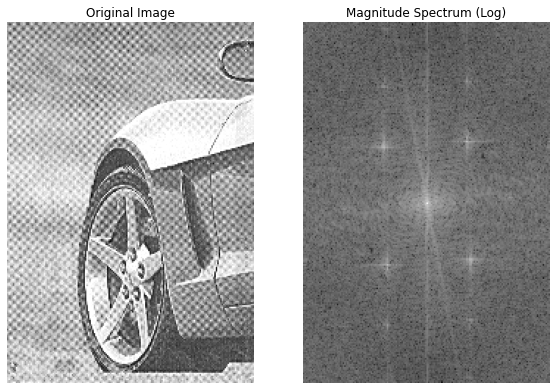

In [3]:
# Reading and displaying the image/image spectrum (log)

img = cv2.imread("car_moire.tif", 0)

img_dft = np.fft.fft2(img)
fshift = np.fft.fftshift(img_dft)

spectrum_log = 1 + np.log(np.abs(fshift))

show2(img, "Original Image", spectrum_log, "Magnitude Spectrum (Log)")

In [4]:
# Approximate notch coordinates

delta_x = img.shape[1]//3
delta_y = img.shape[0]//6

notch_h = [i*delta_y for i in range(-2,3) if i != 0]
notch_w = [i*(delta_x//2) for i in range(-1, 2) if i != 0]

## Applying Reject Notch Filters

### Gaussian

/home/ggc5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


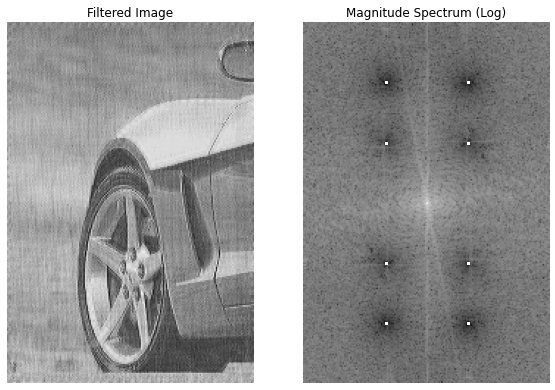

In [5]:
H_gaussian = reject_notch_filter(img.shape[0], img.shape[1], notch_h, notch_w, 15, 4, "GHPF")
apply_rn_filter(fshift, H_gaussian)

### Butterworth

/home/ggc5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/home/ggc5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


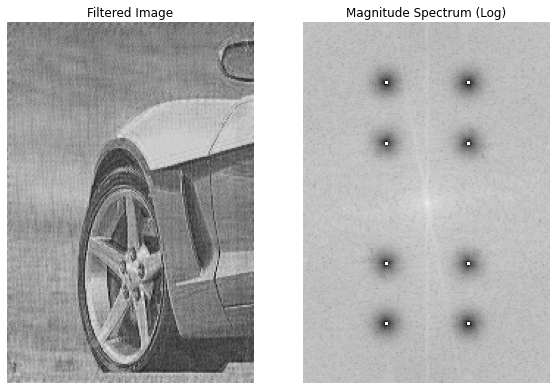

In [6]:
H_butterworth = reject_notch_filter(img.shape[0], img.shape[1], notch_h, notch_w, 15, 4, "BHPF")
apply_rn_filter(fshift, H_butterworth)

### Ideal

/home/ggc5/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


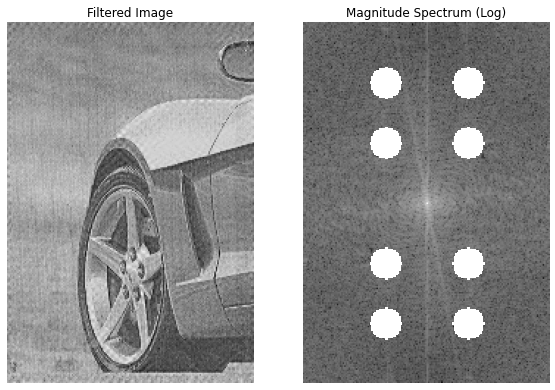

In [7]:
H_ideal = reject_notch_filter(img.shape[0], img.shape[1], notch_h, notch_w, 10, 4, "IHPF")
apply_rn_filter(fshift, H_ideal)